# Synthesis
```{eval-rst}
.. index:: DFT ; synthesis, additive synthesis
```

In [1]:
%run ../setup.ipynb

In the first section of this chapter, we saw how a signal $\blue{x[n]}$ representing a sinusoid at an analysis frequency can be reconstructed from its DFT coefficients $\darkblue{X[m]}$.
In the second section, we saw (abstractly) that this is true of **any** signal $\blue{x[n]}$, not just sinusoids.
In this section, we'll unpack this a bit and look more carefully at some examples to get a better intuition for how this works.

The key idea is that the IDFT can be thought of as an example of **additive synthesis**: the signal $\blue{x[n]}$ is reconstructed as a combination of pure tones.

## IDFT as synthesis

Equation {eq}`idft` tells us how to construct the $n$th sample of a signal $x$ as an average of the following terms:
```{math}
\blue{x[n]} = \frac{1}{N} \sum_{m=0}^{N-1} \darkblue{X[m]} \cdot \green{e^{2\pi\cdot\mathsf{j}\cdot \frac{m}{N} \cdot n}}
```
Remember that each DFT coefficient $\darkblue{X[m]}$ is a complex number with an amplitude (we'll call it $A_m$) and a phase ($\phi_m$):
```{math}
\darkblue{X[m]} = A_m \cdot e^{\mathsf{j}\cdot \phi_m}
```
This means that each term in IDFT summation can be equivalently expressed as
```{math}
A_m \cdot e^{\mathsf{j}\cdot \phi_m}\cdot \green{e^{2\pi\cdot\mathsf{j}\cdot \frac{m}{N} \cdot n}} = A_m \cdot e^{\mathsf{j}\cdot\left(\green{2\pi \cdot \frac{m}{N} \cdot n} + \phi_m\right)}.
```
Equivalently, we can use Euler's formula to express this as waves instead of an exponential:
```{math}
A_m \cdot \red{\cos\left(2\pi \cdot \frac{m}{N} \cdot n + \phi_m\right)} + \mathsf{j}\cdot A_m \cdot \purple{\sin\left(2\pi \cdot \frac{m}{N} \cdot n + \phi_m\right)}.
```
This says that each term in the summation has a real part (the cosine term) and an imaginary part (the sine term), but they both share the same amplitude $A_m$, frequency $m/N$, and phase $\phi_m$.

As we saw in our [warmup example](idft-sinusoid) earlier in the chapter, if the DFT has conjugate symmetry (so that $X[m] = \overline{X[N-m]}$), then the imaginary term corresponding to $X[m]$ will cancel with the imaginary term corresponding to $X[N-m]$ when we sum over all frequencies.
This results in an entirely real-valued summation, where each term is produced by a sinusoid in standard form:
```{math}
:label: idft-real
\blue{x[n]} = \frac{1}{N} \sum_{m=0}^{N-1} A_m \cdot \red{\cos\left(2\pi \cdot \frac{m}{N} \cdot n + \phi_m\right)}.
```
````{margin}
```{note}
If you've been wondering why we defined the standard form of sinusoids {eq}`sinusoid` by using cosine instead of sine, {eq}`idft-real` is why.
We could have equivalently written this equation using sine, but there would be extra phase offsets of $\pi/2$ to keep track of.
```
````
Note that this *only* works if the spectrum is conjugate symmetric.
If we don't have conjugate symmetry, then the reconstructed signal may have complex values.

## Example: partial reconstruction

The inverse DFT equation tells us how to reconstruct a signal from its spectrum, but we can also gain an intuition for how this works by looking at what happens when we stop the summation early, including only some $N' < N$ frequencies.

To visualize this process, we'll revisit the [trumpet example](trumpet-recording) from earlier.
To keep the visualization simple, we'll take only a small fragment of the recording for analysis.

In [2]:
# We'll use soundfile to load the signal
import soundfile as sf

# And IPython to play it back in the browser
from IPython.display import Audio, display

# A single note (D#5) played on a trumpet
# https://freesound.org/s/48224/
# License: CC BY-NC 3.0
x, fs = sf.read('48224__slothrop__trumpetf3.wav')

# Slice out 512 samples (approximately 11ms) of audio
x = x[int(0.3 * fs):int(0.3*fs)+512]

Plotting the time-domain signal, along with its magnitude spectrum results in {numref}`partial-signal`.

<Figure size 432x216 with 2 Axes>

<Figure size 432x216 with 2 Axes>

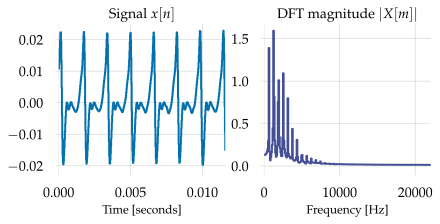

In [3]:
# How many samples do we have?
N = len(x)

# Compute its DFT
X = np.fft.rfft(x)

# and plot both the signal and its spectrum
fig, (ax_time, ax_freq) = plt.subplots(ncols=2, figsize=figaspect(0.5))

# get the sample times for x
time = np.arange(N) / fs

# plot the signal
ax_time.step(time, x, where='post')  

ax_time.set(xlabel='Time [seconds]', title='Signal $x[n]$')

# plot the magnitudes |X[m]|
freqs = np.fft.rfftfreq(N, 1/fs)
ax_freq.step(freqs, np.abs(X), where='post', color=colors[11])  

# We'll shade the negative frequency range
#ax_freq.axvspan(N/2, N, color='k', alpha=0.1, zorder=-1)  
ax_freq.set(xlabel='Frequency [Hz]', title='DFT magnitude $|X[m]|$')
glue('partial-signal', fig, display=False);

```{glue:figure} partial-signal
---
name: partial-signal
alt: a trumpet waveform and its DFT magnitudes
---

*Left*: Approximately 11ms (512/44100) excerpt of a trumpet playing D♯.
*Right*: The DFT magnitude spectrum of the signal (positive frequencies only).
```

We can see that the signal contains a repeating pattern, but also that it does not closely resemble a sinusoid.
The DFT spectrum ({numref}`partial-signal`, right) contains many peaks, indicating that the signal does indeed contain a rich combination of sinusoids.
{numref}`idft-partial` below demonstrates how the signal would be approximated if only part of the DFT spectrum is used in the reconstruction.

<Figure size 576x576 with 10 Axes>

<Figure size 576x576 with 10 Axes>

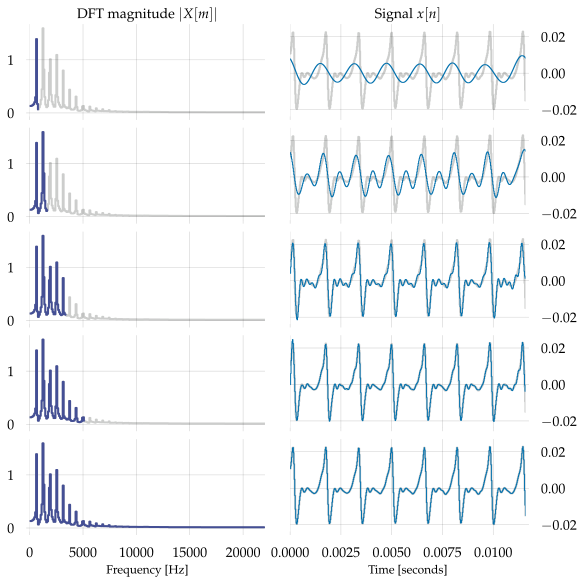

In [22]:
# Generate all partial spectra
X_partial = X[:] * np.tril(np.ones(len(X)))
# And all partial reconstructions
x_partial = np.fft.irfft(X_partial, axis=1)

# and plot both the signal and its spectrum
fig, axes = plt.subplots(ncols=2, nrows=5, sharex='col', sharey='col', figsize=(8, 8))

# get the sample times for x
time = np.arange(N) / fs
freqs = np.fft.rfftfreq(N, 1/fs)

axes[0, 0].set(title='DFT magnitude $|X[m]|$')
axes[0, 1].set(title='Signal $x[n]$')
for ax in axes[:, 0]:
    ax.step(freqs, np.abs(X), where='post', color=colors[3], zorder=-1, alpha=0.25, linewidth=2)
    ax.set(xlabel='Frequency [Hz]');

for ax in axes[:, 1]:
    ax.step(time, x, where='post', alpha=0.25, zorder=-1, color=colors[3], linewidth=2)
    ax.set(xlabel='Time [seconds]')
    ax.yaxis.tick_right()

for i, parts in enumerate([10, 20, 40, 60, N//2]):
    
    # plot the signal
    axes[i, 1].step(time, x_partial[parts], where='post', color=colors[0], linewidth=1)[0]

    # plot the magnitudes |X[m]|
    axes[i, 0].step(freqs[:parts], np.abs(X_partial[parts, :parts]), where='post', color=colors[11])[0]

    
for ax in axes.flat:
    ax.label_outer()

glue('idft-partial', fig, display=False)

```{glue:figure} idft-partial
---
name: idft-partial
alt: illustration of partial sum reconstruction of a signal from its DFT coefficients
---

As more DFT coefficients $\darkblue{X[m]}$ are included in the reconstruction (*left*), the reconstruction (*right*) better approximates the original input signal $\blue{x[n]}$.
Note here that only the positive frequencies ($m=0, 1, \dots, N/2$) are visualized here, and that each partial reconstruction up to frequency index $m$ contains both $m$ and $N-m$.
```

A careful look at {numref}`idft-partial` reveals that the reconstruction converges fairly quickly to a good approximation of the original signal $x[n]$.
While the later terms in the summation (corresponding to frequencies above 5000 Hz) contribute only small amounts to the sum, they are critical to capturing the beginning and end of the signal.
This is because the signal we've excerpted is discontinuous at the boundaries, and as we saw in the discussion of [spectral leakage](leakage), discontinuities require high-frequency content to accurately represent.

Finally, it is worth remembering that the visualization above does not illustrate the *phase* $\phi_m$ of the sinusoids being used in the reconstruction.
This is primarily to keep the visualization simple: the phase content is still important to accurate reconstruction of the signal!